In [33]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

import sys

In [37]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(device)

mps


In [60]:
data = np.loadtxt(open('../00-Dataset/mnist_train_small.csv', 'rb'), delimiter=',')

### Move the data to MPS

In [61]:
data.shape
labels = data[:,0]
data = data[:,1:]


In [62]:
# normalize the data to a range of [0, 1]
dataNorm = data/np.max(data)

In [63]:
dataNorm.shape

(20000, 784)

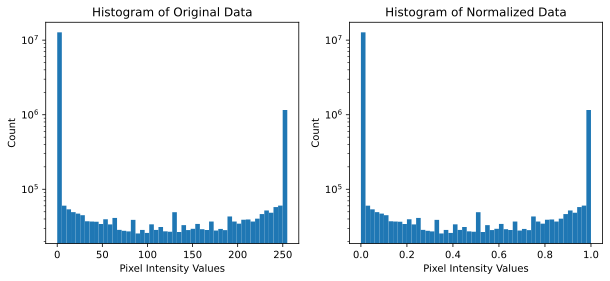

In [64]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].hist(data.flatten(),50)
ax[0].set_xlabel('Pixel Intensity Values')
ax[0].set_ylabel('Count')
ax[0].set_title('Histogram of Original Data')
ax[0].set_yscale('log')

ax[1].hist(dataNorm.flatten(),50)
ax[1].set_xlabel('Pixel Intensity Values')
ax[1].set_ylabel('Count')
ax[1].set_title('Histogram of Normalized Data')
ax[1].set_yscale('log')
plt.show()

In [65]:
# convert data to tensor
dataT = torch.tensor(dataNorm).float()
labelsT = torch.tensor(labels).long() # long = int64

train_data, test_data, train_labels, test_labels = train_test_split(dataT, labelsT, train_size = 0.9)

train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

batchSize = 1024 # with small batch size the MPS speed is slower than CPU
train_loader = DataLoader(train_data, batch_size=batchSize, drop_last=True, shuffle=True)
test_loader = DataLoader(test_data, batch_size=test_data.__len__())


In [66]:
class Model(nn.Module):
    def __init__ (self, nUnits, nLayers):
        super().__init__()

        self.nUnits = nUnits
        self.nLayers = nLayers

        self.layers = nn.ModuleDict()
        self.layers['input'] = nn.Linear(784, self.nUnits)

        for n in range(self.nLayers):
            self.layers[f'hidden-{n}'] = nn.Linear(self.nUnits, self.nUnits)

        self.layers['output'] = nn.Linear(nUnits, 10)

    def forward(self, data):
        x = F.relu(self.layers['input'](data))

        for n in range(self.nLayers):
            x = F.relu(self.layers[f'hidden-{n}'](x))

        x = torch.log_softmax(self.layers['output'](x), axis=1)
        # log_softmax() because of NLLLoss instead of CrossEntropyLoss

        return x

In [67]:
def getModel(nUnits, nLayers):
    ANN = Model(nUnits, nLayers)
    lossFunction = nn.NLLLoss()
    optimizer = torch.optim.SGD(params=ANN.parameters(), lr=0.01)

    return ANN, lossFunction, optimizer

In [68]:
# test above function/class
ANN, lossFunction, optimizer = getModel(2, 3)
ANN.to(device)
ANN

# X, y = next(iter(train_loader))

# yHat = ANN(X)
# print(yHat) # these are the log of probabilities that the model outputs. Log, beacuse of log_softmax()
# print(torch.exp(yHat)) # undoing the log. These will be between 0 and 1



Model(
  (layers): ModuleDict(
    (input): Linear(in_features=784, out_features=2, bias=True)
    (hidden-0): Linear(in_features=2, out_features=2, bias=True)
    (hidden-1): Linear(in_features=2, out_features=2, bias=True)
    (hidden-2): Linear(in_features=2, out_features=2, bias=True)
    (output): Linear(in_features=2, out_features=10, bias=True)
  )
)

In [69]:
def trainModel(ANN, lossFunction, optimizer):
    epochs = 60

    losses = torch.zeros(epochs)
    trainAcc = []
    testAcc = []

    ANN.to(device)

    for _ in range(epochs):
        batchAcc = []
        batchLoss = []
        for x, y in train_loader:
            
            # Move data to Device
            x = x.to(device)
            y = y.to(device)

            yHat = ANN.forward(x)
            loss = lossFunction(yHat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLoss.append(loss.item())

            # Bring data back to CPU
            yHat = yHat.cpu()
            y = y.cpu()
            
            batchAcc.append(torch.mean((torch.argmax(yHat, axis=1)==y).float())*100)

        trainAcc.append(np.mean(batchAcc))
        losses[_] = np.mean(batchLoss)

        X, Y = next(iter(test_loader))

        # Move data to Device
        X = X.to(device)
        Y = Y.to(device) # not required to move to device

        with torch.no_grad():
            pred = ANN(X)

        # Bring data back to CPU
        pred = pred.cpu()
        Y = Y.cpu()

        testAcc.append(torch.mean((torch.argmax(pred, axis=1)==Y).float())*100)

    return trainAcc, testAcc, losses, ANN

In [70]:
unitsArr = np.arange(50, 251, step=50)
layersArr = range(1, 4)
finalTrainAcc = np.zeros((len(unitsArr), len(layersArr)))
finalTestAcc = np.zeros((len(unitsArr), len(layersArr)))

for layersIdx in range(len(layersArr)):
    for unitsIdx in range(len(unitsArr)):
        ANN, lossFunction, optimizer = getModel(unitsArr[unitsIdx], layersArr[layersIdx])
        trainAcc, testAcc, losses, ANN = trainModel(ANN, lossFunction, optimizer)

        finalTrainAcc[unitsIdx, layersIdx] = np.mean(trainAcc[-5:])
        finalTestAcc[unitsIdx, layersIdx] = np.mean(testAcc[-5:])

        message = 'Completed experiment {}/{}'.format(layersIdx*len(unitsArr)+(unitsIdx+1),len(unitsArr)*len(layersArr))
        sys.stdout.write("\r" + str(message))

Completed experiment 15/15

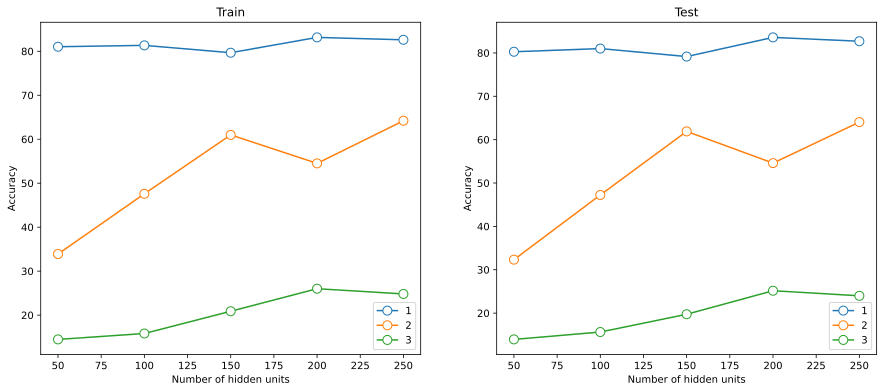

In [71]:
# show accuracy as a function of model depth
fig,ax = plt.subplots(1,2,figsize=(15,6))

ax[0].plot(unitsArr,finalTrainAcc,'o-',markerfacecolor='w',markersize=9)
ax[1].plot(unitsArr,finalTestAcc,'o-',markerfacecolor='w',markersize=9)

for i in range(2):
  ax[i].legend(layersArr)
  ax[i].set_ylabel('Accuracy')
  ax[i].set_xlabel('Number of hidden units')
  ax[i].set_title([ 'Train' if i==0 else 'Test' ][0])

plt.show()